### Exercise 10.1

In [15]:
import numpy as np
import sys
from matplotlib import pyplot as plt
sys.path.append('../python_scripts')
from GMesh2d import MESH2D
from GHeatConservationSolver import EXPLICIT_SOLVER

#### Initiate a 2d mesh

This MESH2D class is defined in "python_scripts/GMesh2d.py". 
Here, we use a regular grid of 51 × 31 points. The model size is 1000 × 1500 km2 (i.e. 1 000 000 × 1 500 000 m2). 

In [16]:
# initiate mesh
xsize = 1000000.0 # Model size, m
ysize = 1500000.0
xnum = 11   # Number of nodes
ynum = 16
xs = np.linspace(0.0, xsize, xnum) # construct xs 
ys = np.linspace(0.0, ysize, ynum) # construct ys
Mesh2d = MESH2D(xs, ys)

#### Read in the initial temperature

The initial setup corresponds to a background temperature of 1000 K with a rectangular thermal wave (1300 K) in the middle (‘wave’ means sharp perturbation of the temperature field).

(16, 11)


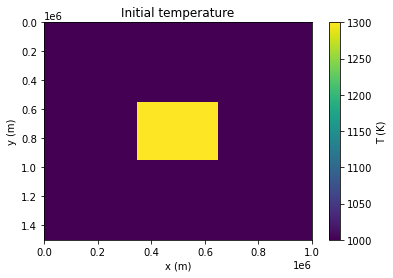

In [17]:
# initial temperature
def rectangular_wave_temperature(x, y, xsize, ysize):
    '''
    temperature profile of a retangular wave in the middle
    '''
    dx = xsize / 3.0
    dy = ysize / 3.0
    if type(x) == float and type(y) == float:
      assert(x >= 0 and x <= xsize and y >= 0 and y <= ysize)
      if x > (xsize - dx) / 2.0 and x < (xsize + dx) / 2.0\
        and y > (ysize - dy) / 2.0 and y < (ysize + dy) / 2.0:
        T = 1300.0
      else:
        T = 1000.0
    elif type(x) == np.ndarray and type(y) == np.ndarray:
      assert(x.shape == y.shape)
      mask = (x > (xsize - dx) / 2.0) & (x < (xsize + dx) / 2.0)\
        & (y > (ysize - dy) / 2.0) & (y < (ysize + dy) / 2.0)
      T = np.ones(x.shape) * 1000.0
      T[mask] = 1300.0
    else:
      raise TypeError("Type of x or y is wrong (either float or numpy.ndarray")
    return T

xxs, yys = np.meshgrid(xs, ys)
Ts_init = rectangular_wave_temperature(xxs, yys, xsize, ysize)
print(Ts_init.shape)  # debug

# plot
fig, ax = plt.subplots()
h = ax.pcolor(xxs, yys, Ts_init)
ax.set_title('Initial temperature')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim([0.0, xsize])
ax.set_ylim([0.0, ysize])
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label='T (K)')

#### Solve the problem

An explicit FD is used with Eq (10.4) from the textbook. 
Use constant thermal conductivity k = 3 W/(m K), density ρ = 3200 kg/m 3 and heat capacity CP = 1000 J/(kg K) for the entire model. 

The limit of time step is given by $t_m = \frac{\Delta x^2}{2\kappa}$, thus we first output this value below.

In [18]:
year = 365 * 24 * 3600.0
thermal_conductivity = 3
rho = 3200.0
cp = 1000.0
kappa = thermal_conductivity / rho / cp  # thermal diffusivity
dt_m = (xsize / (xnum-1.0)) / (2*kappa)
print("Limit on time step: %.4e year" % (dt_m / year))

Limit on time step: 1.6912e+03 year


With this estimation, we first test a scenario where the time increment is choses as $0.6 t_m$

Temperature solver: 4.9949e-04 s to solver
Temperature solver: 2.8992e-04 s to solver
Temperature solver: 2.7323e-04 s to solver
Temperature solver: 2.5034e-04 s to solver
Temperature solver: 2.6917e-04 s to solver
Temperature solver: 3.2353e-04 s to solver
Temperature solver: 2.8777e-04 s to solver
Temperature solver: 2.7204e-04 s to solver
Temperature solver: 2.6274e-04 s to solver
Temperature solver: 2.8229e-04 s to solver


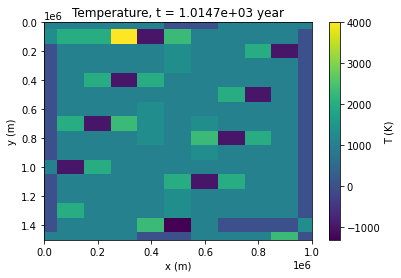

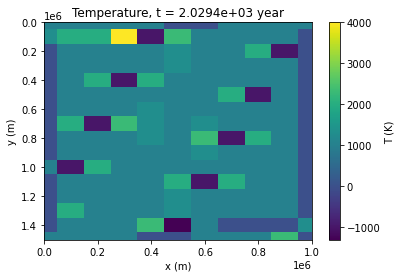

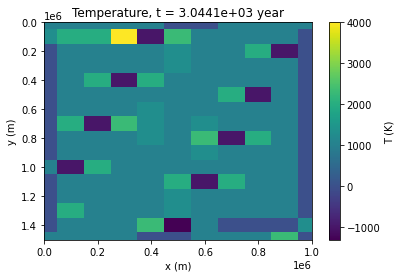

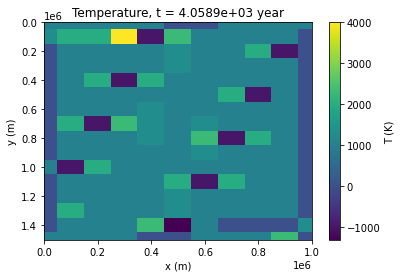

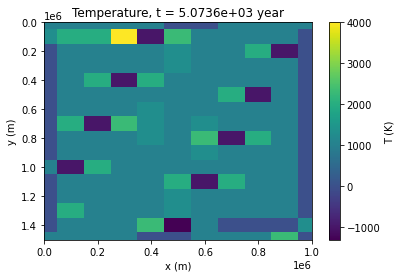

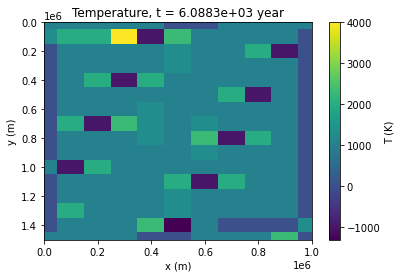

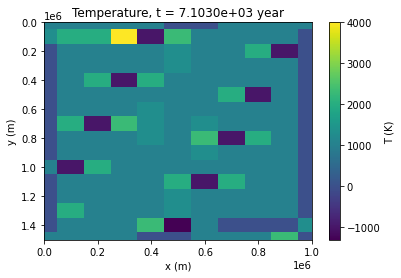

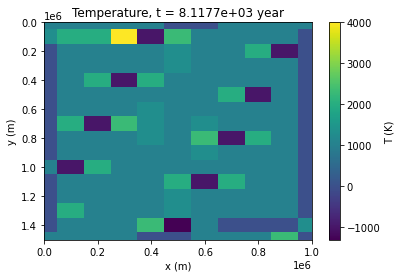

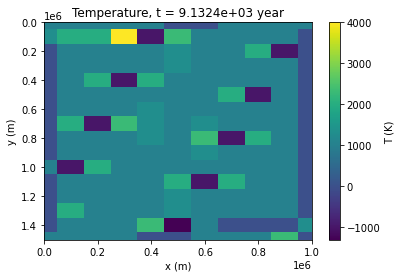

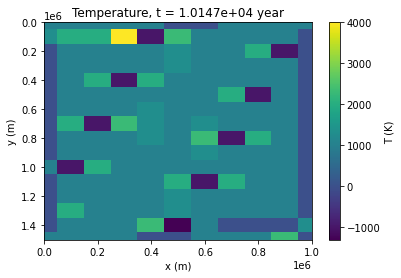

In [20]:
dt = 0.6 * dt_m
total_step = 10
# initiate solver
HCSolver = EXPLICIT_SOLVER(Mesh2d, use_constant_thermal_conductivity=True)
HCSolver.initial_temperature(Ts_init)  # use the rectangular perturbation as the initial temperature
HCSolver.assemble(thermal_conductivity, rho, cp, dt)

for step in range(total_step):
    # solve
    HCSolver.solve()
    # export and plot
    xxs, yys, Ts = HCSolver.export()
    t = HCSolver.get_time()
    fig, ax = plt.subplots()
    h = ax.pcolor(xxs, yys, Ts)
    ax.set_title('Temperature, t = %.4e year' % (t/year))
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_xlim([0.0, xsize])
    ax.set_ylim([0.0, ysize])
    ax.invert_yaxis()
    fig.colorbar(h, ax=ax, label='T (K)')